# 0.0 Imports

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import datetime

from IPython.core.display import display, HTML
from matplotlib import pyplot as plt
from scipy import stats as ss

from boruta import BorutaPy

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso


## 0.1 Helper Funcitons

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [3]:
def cramer_v(x, y):
    cm = pd.crosstab(a['state_holiday'], a['store_type']).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max (0, chi2 - (k-1) * (r-1) / (n-1) )
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)

    return np.sqrt( (chi2corr/n) / ( min(kcorr-1, rcorr-1) ) )

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs( (y - yhat) / y) )

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    msre = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': msre}, index=[0])

## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Data Description

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename

df1.columns = cols_new

## 1.2 Data Dimension

In [8]:
print(f'Number of Rows {df1.shape[0]}')
print(f'Number of Columns {df1.shape[1]}')

Number of Rows 1017209
Number of Columns 18


## 1.3 Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'] )

In [10]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [12]:
df1['competition_distance'].max()

75860.0

In [13]:
#competition_distance              
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)  

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)  

#promo2_since_week               
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)  

#promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)  

#promo_interval                  
month_map = {1 : 'Jan', 2 : 'Fev', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sep', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec' }

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64') 
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64') 

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64','datetime64[ns]'])

### 1.7.1 Numerical Atributes

In [18]:
# Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [19]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance', ylabel='Count'>

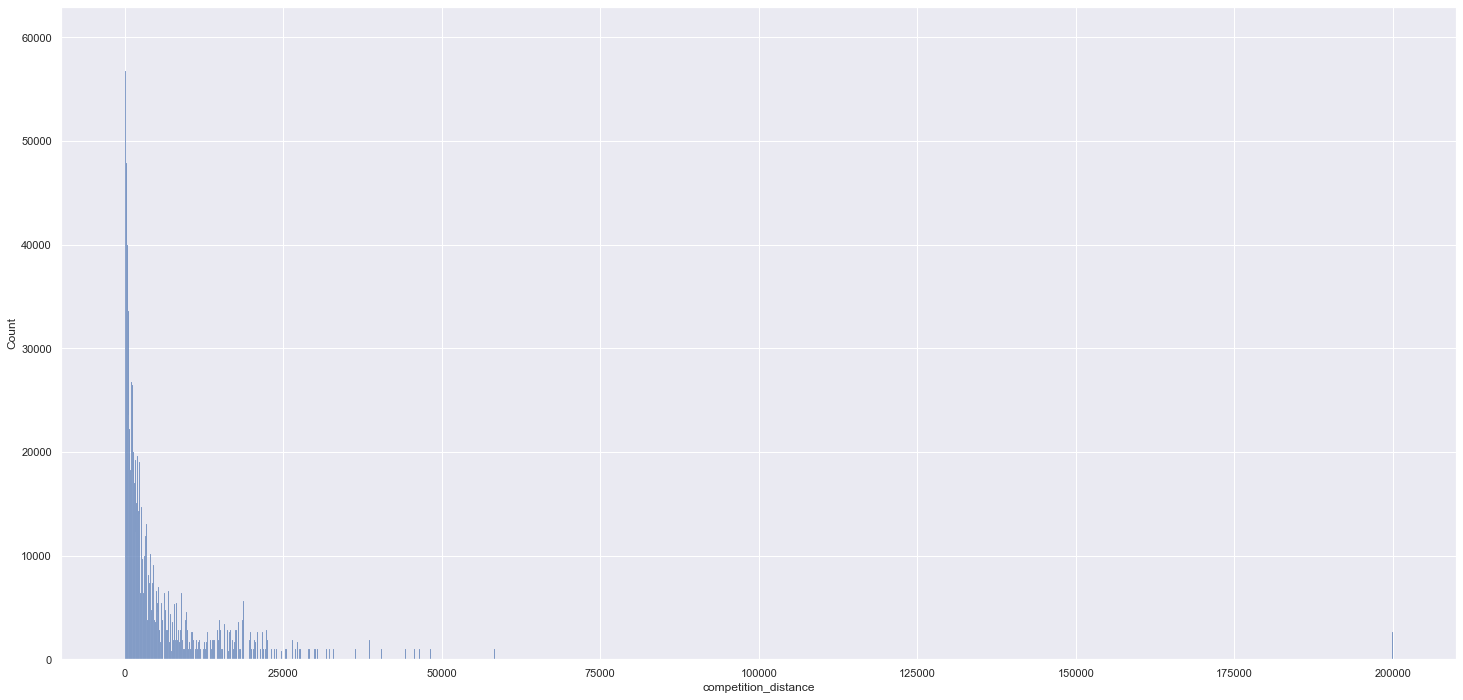

In [20]:
sns.histplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [21]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

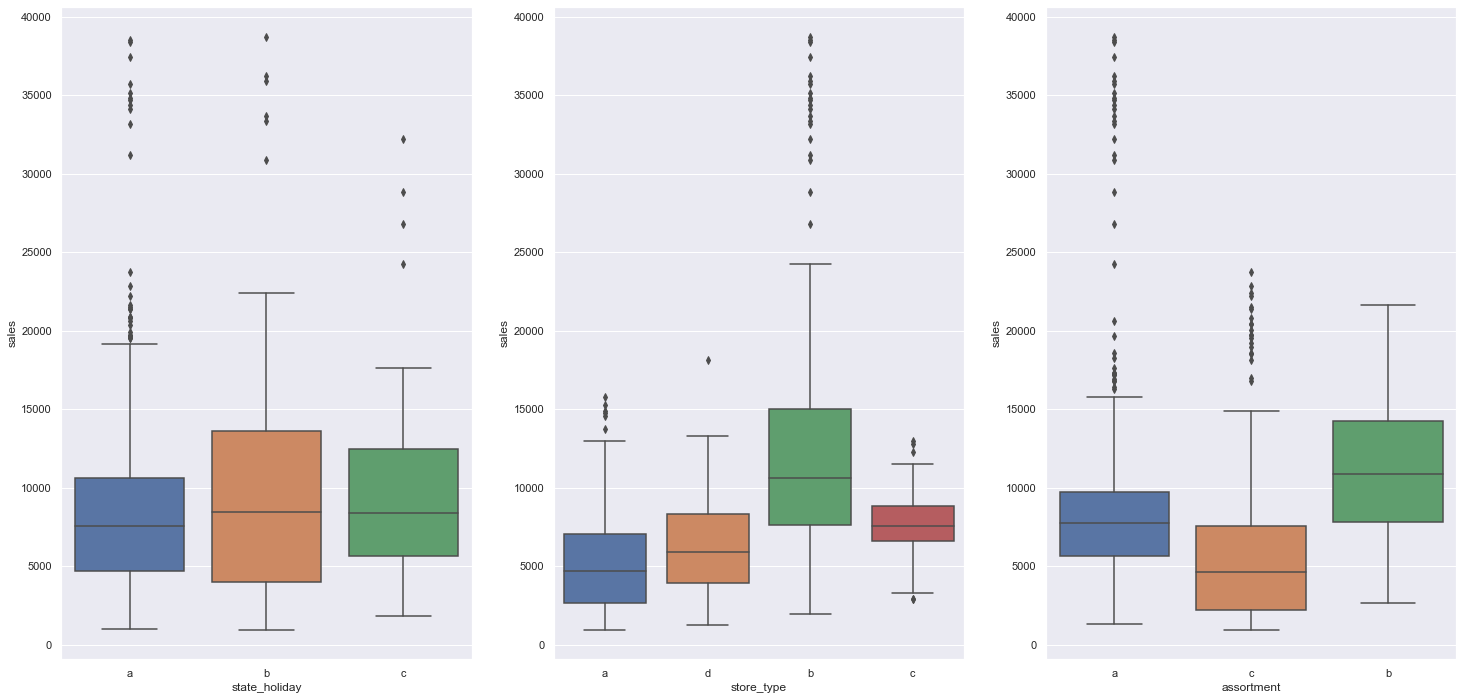

In [22]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x= 'state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x= 'store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x= 'assortment', y='sales', data=aux1)

# 2.0 Feature Engineering

In [23]:
df2 = df1.copy()

## 2.1 Mapa Mental das Hipóteses

## 2.2 Criacação das Hipóteses

## 2.3 Lista Final das Hipóteses

#### 1. Lojas com maior sortimento deveriam vender mais 

#### 2. Lojas com competidores mais próximos deveriam vender menos

#### 3. Lojas com competidores à mais tempo deveriam vender mais

#### 4. Lojas com promoções ativas a mais tempo deveriam vender mais

#### 5. Lojas com mais dias de promoção deveriam vender mais

#### 6. Lojas com promoções consecutivas deveriam vender mais

#### 7. Lojas abertas durante o feriado de Natal deveriam vender mais

#### 8. Lojas deveriam vender mais ao longo dos anos

#### 9. Lojas deveriam vender mais no segundo semestre do ano

#### 10. Lojas deveriam vender mais depois do dia 10 de cada mês

#### 11. Lojas deveriam vender menos aos finais de semana

#### 12. Lojas deveriam vender menos durante os feriados escolares

## 2.4 Feature Engineering

In [24]:
#year
df2['year'] = df2['date'].dt.year 

#month 
df2['month'] = df2['date'].dt.month 

#day
df2['day'] = df2['date'].dt.day 

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week 

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W') 

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'], day= 1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) /30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta (days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) /7 ).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x =='a' else 'extra' if x== 'b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x =='a' else 'easter_holiday' if x == 'b'  else 'christimas' if x == 'c' else 'regular_day')

In [25]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Variable Filtering

In [26]:
df3 = df2.copy()

## 3.1 Row Filtering

In [27]:
df3 = df3[(df3[ 'open'] != 0) & (df3['sales'] > 0 ) ]

## 3.2 Columns Selection

In [28]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop (cols_drop, axis = 1)

# 4.0 Exploratory Data Analysis

In [29]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

C:\Users\Riva\anaconda3\envs\DS em Producao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

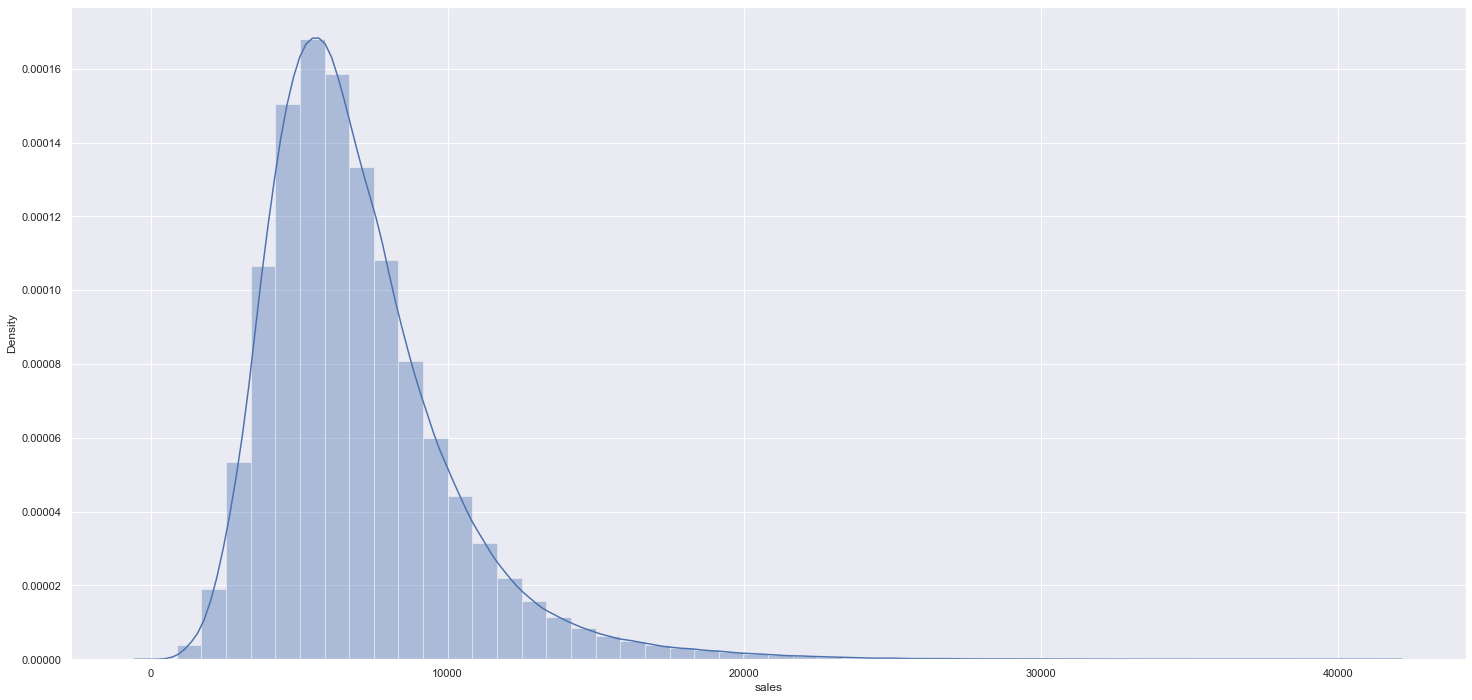

In [30]:
sns.distplot( df4[ 'sales' ] )

### 4.1.2 Numerical Variables

array([[<AxesSubplot:title={'center':'store'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'sales'}>,
        <AxesSubplot:title={'center':'customers'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'promo'}>,
        <AxesSubplot:title={'center':'school_holiday'}>,
        <AxesSubplot:title={'center':'competition_distance'}>],
       [<AxesSubplot:title={'center':'competition_open_since_month'}>,
        <AxesSubplot:title={'center':'competition_open_since_year'}>,
        <AxesSubplot:title={'center':'promo2'}>,
        <AxesSubplot:title={'center':'promo2_since_week'}>],
       [<AxesSubplot:title={'center':'promo2_since_year'}>,
        <AxesSubplot:title={'center':'is_promo'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

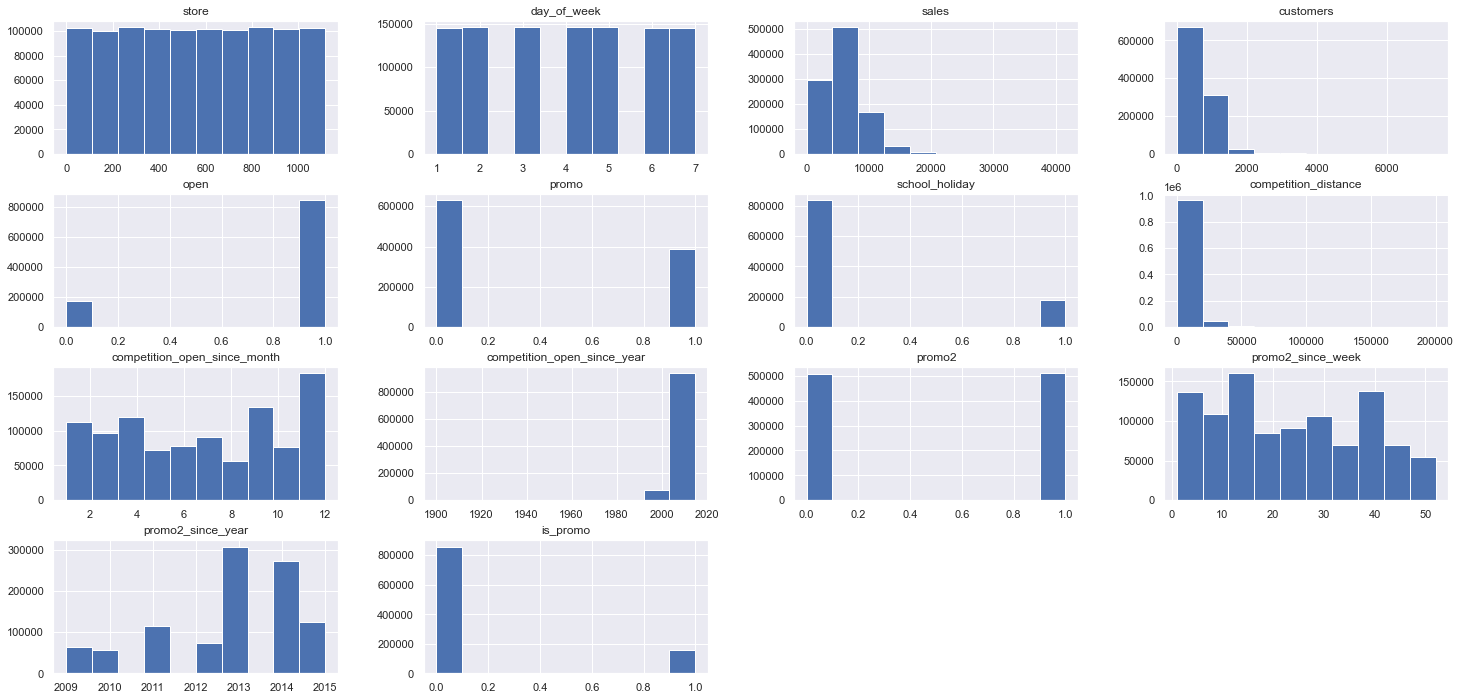

In [31]:
num_attributes.hist()

### 4.1.3 Categorical Variables

In [32]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

C:\Users\Riva\anaconda3\envs\DS em Producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Riva\anaconda3\envs\DS em Producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Riva\anaconda3\envs\DS em Producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpr

<AxesSubplot:xlabel='sales', ylabel='Density'>

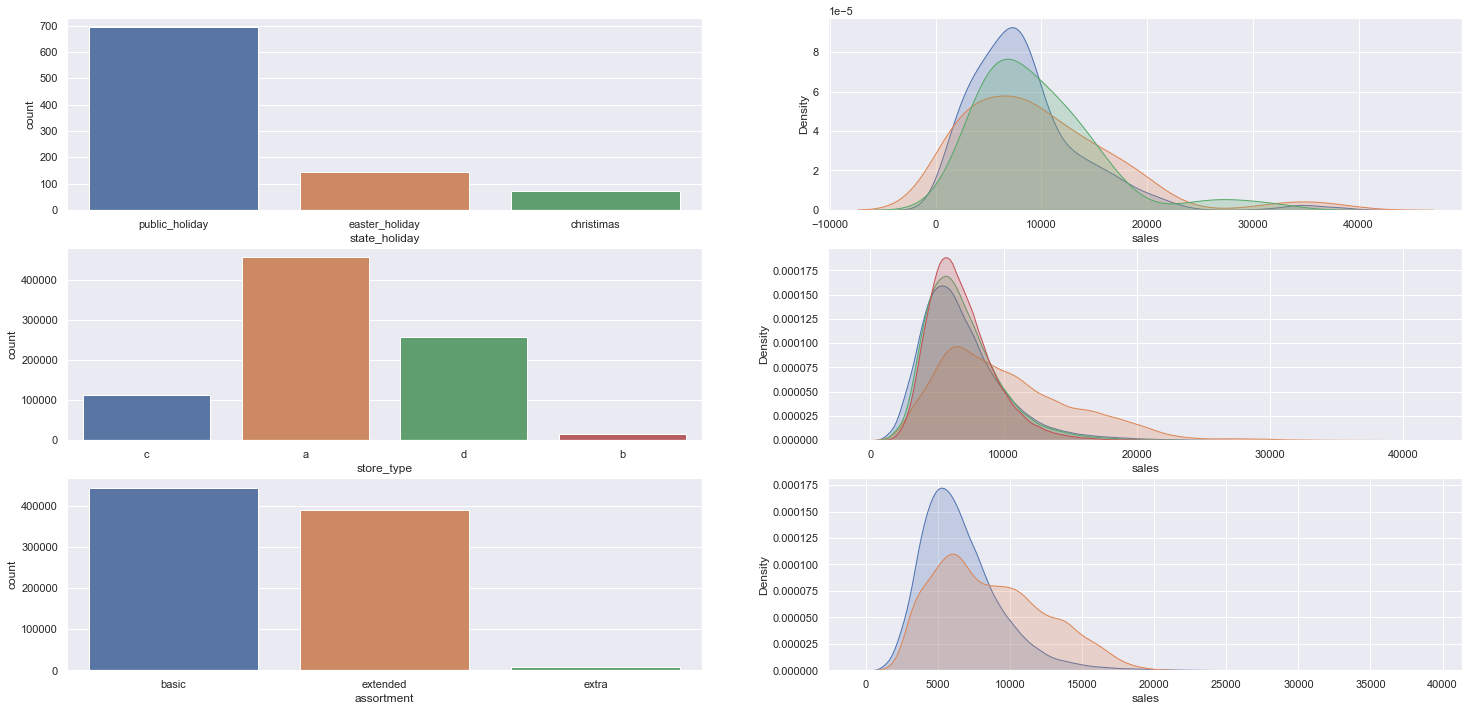

In [33]:
#state holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label= 'public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label= 'easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christimas']['sales'], label= 'christimas', shade=True)

#store type
plt.subplot(3, 2, 3)
sns.countplot( df4['store_type'] )

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label= 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label= 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label= 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label= 'd', shade=True)

#assortment
plt.subplot(3, 2, 5)
sns.countplot( df4['assortment'] )

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extendend']['sales'], label= 'extendend', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label= 'basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label= 'extra', shade=True)

## 4.2 Bivariate Analysis

### **H1**  Lojas com maior sortimento deveriam vender mais 

**FALSA** Lojas com **Maior sortimento** vendem **Menos**

<AxesSubplot:xlabel='year_week'>

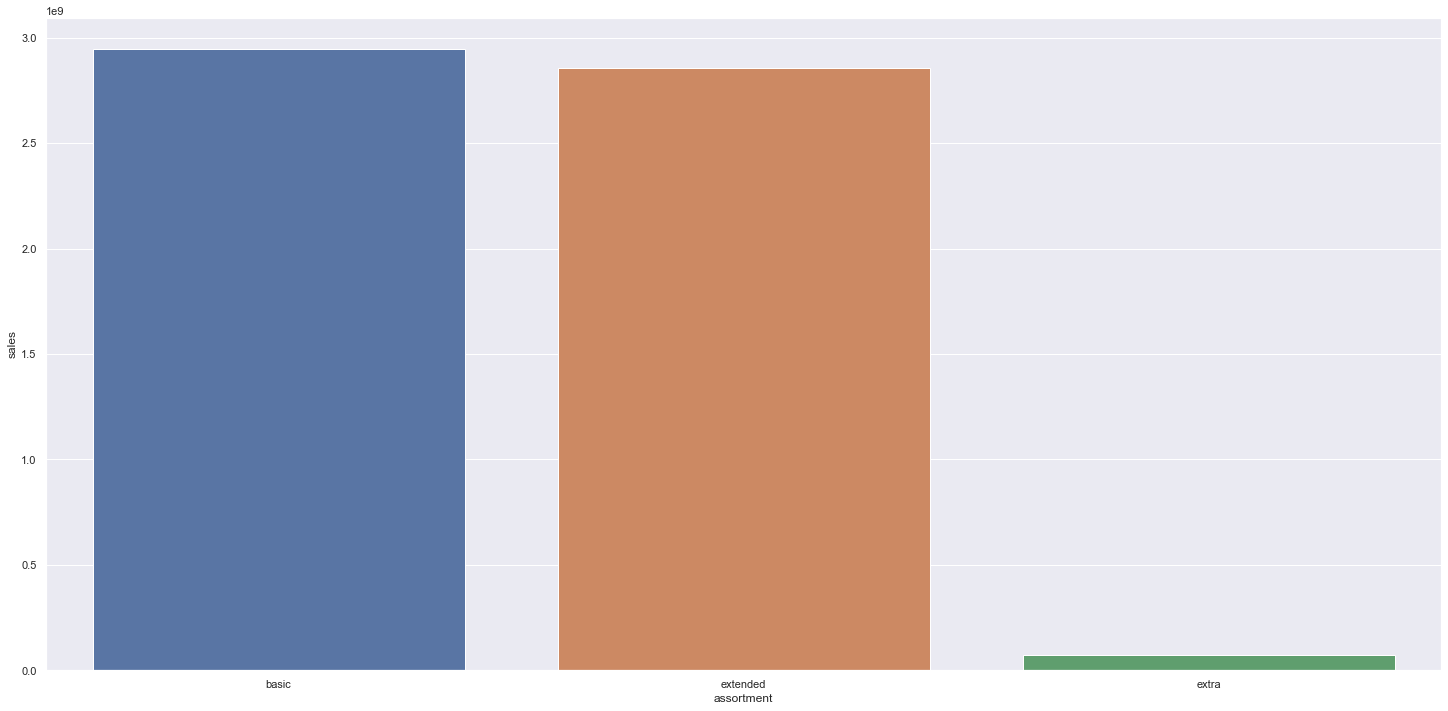

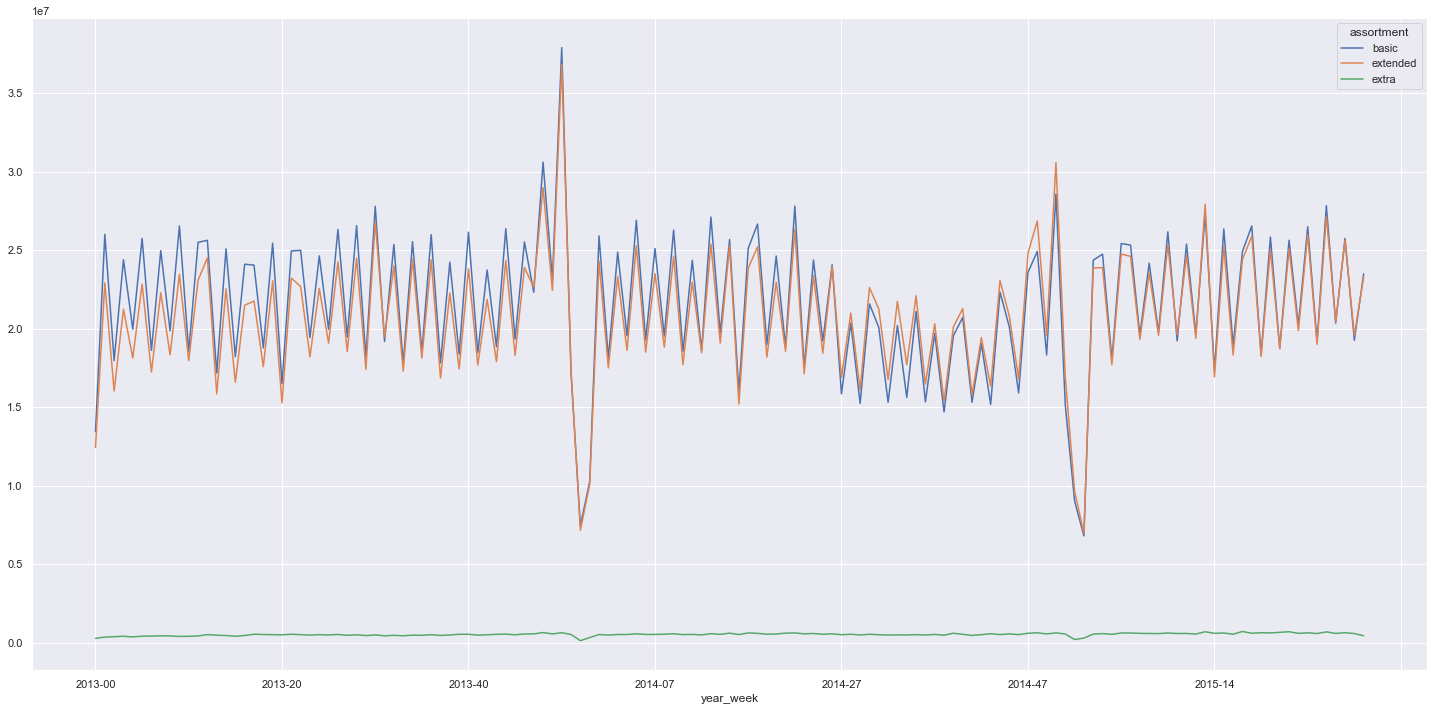

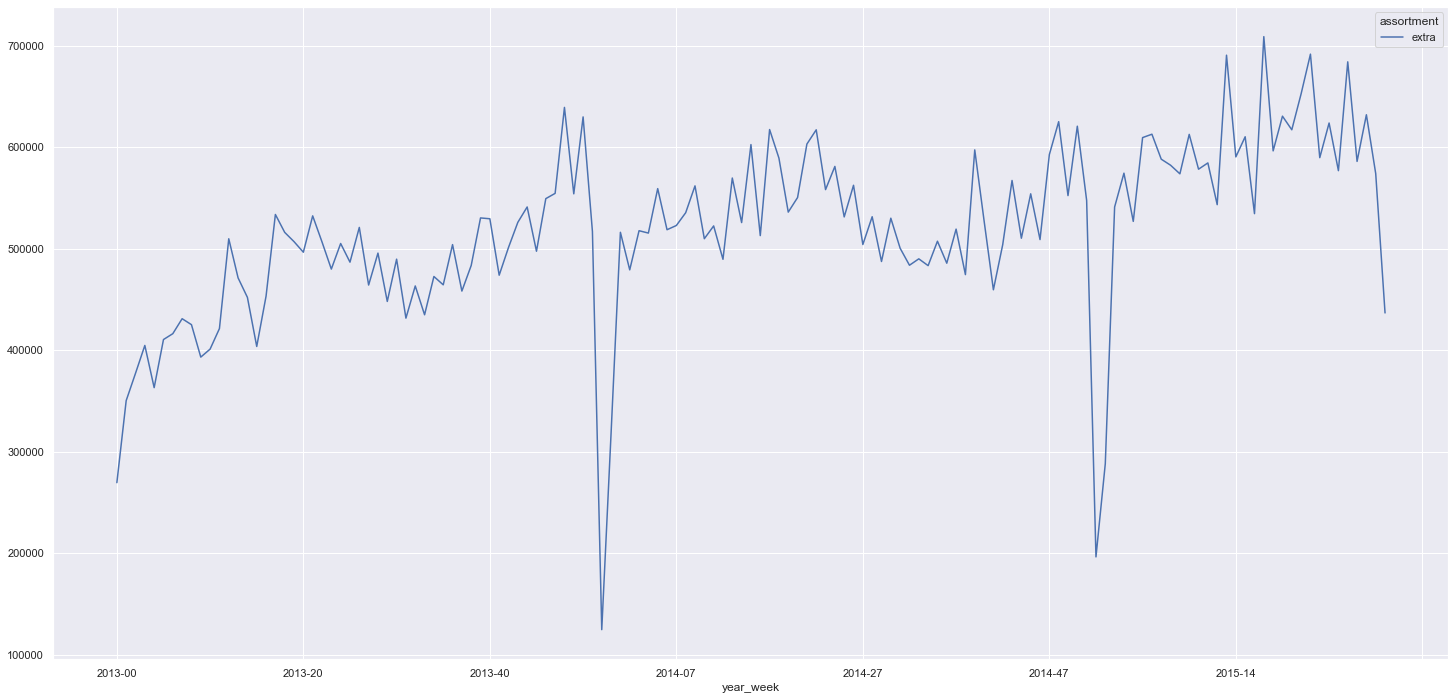

In [34]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### **H2**  Lojas com competidores mais próximos deveriam vender menos
**FALSA** Lojas com **competidores mais próximos** vendem **MAIS**

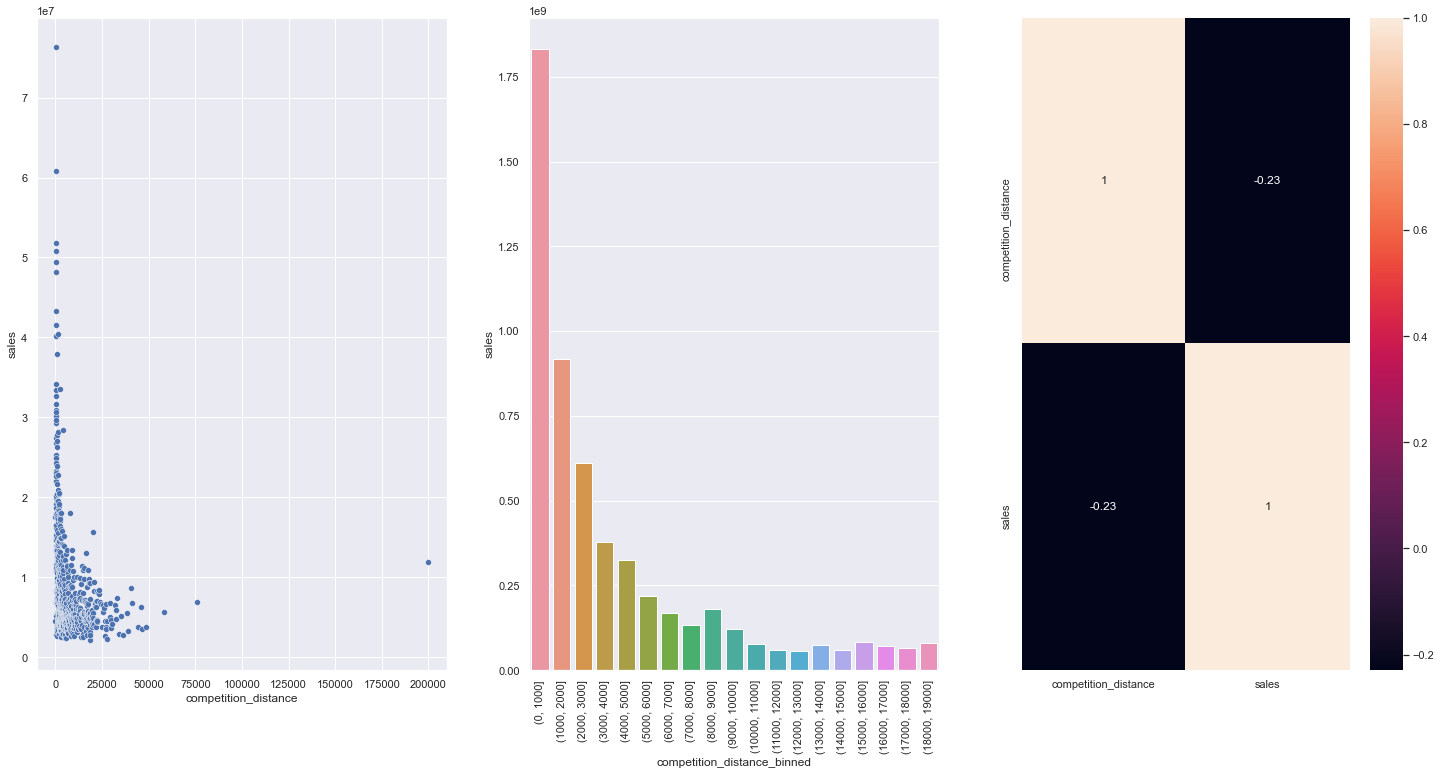

In [35]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90); 

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

In [36]:
aux1.sample(4)

,competition_distance,sales,competition_distance_binned
636,30360.0,4127609,NaN
612,22350.0,4430153,NaN
323,4450.0,9834814,"(4000.0, 5000.0]"
529,13750.0,5072945,"(13000.0, 14000.0]"


### **H3** Lojas com competidores à mais tempo deveriam vender mais

**FALSA** Lojas com **competidores à mais tempo** vendem **Menos**

<AxesSubplot:>

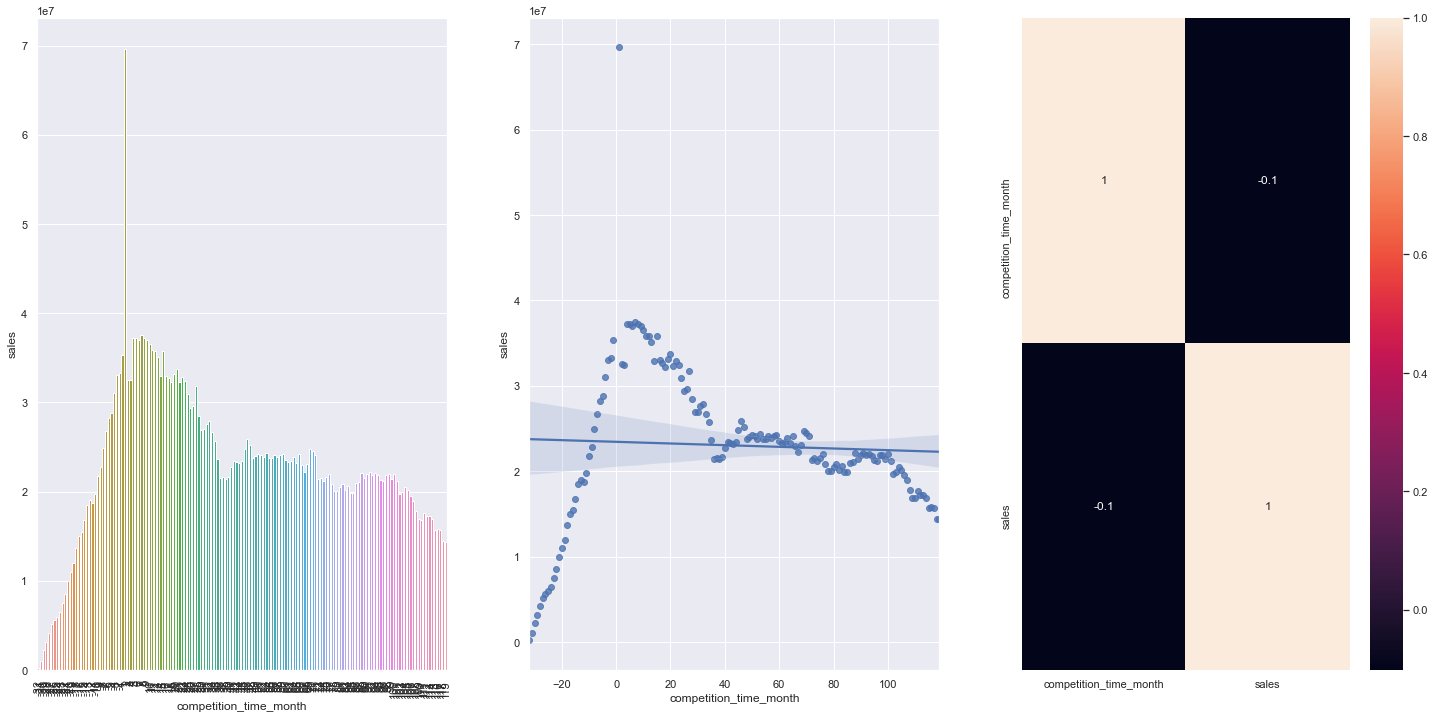

In [37]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[ (aux1['competition_time_month'] < 120 ) & (aux1[ 'competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H4** Lojas com promoções ativas a mais tempo deveriam vender mais
**FALSA** Lojas com **promoções ativas a mais tempo** vendem **Menos depois de um tempo**

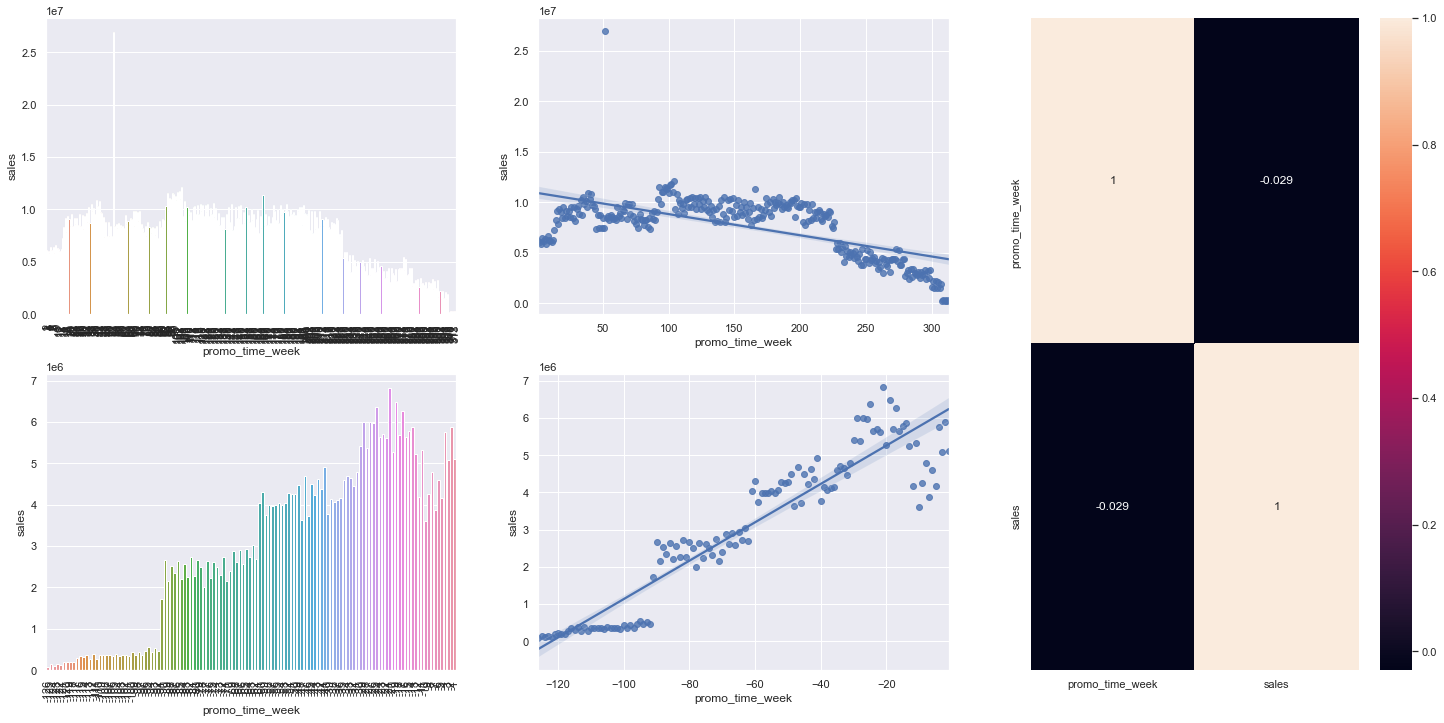

In [38]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0 ] #promo extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0 ] #promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr('pearson'), annot=True );

### <s>**H5** Lojas com mais dias de promoção deveriam vender mais</s>

### **H6** Lojas com promoções consecutivas deveriam vender mais
**FALSA** Lojas com **mais promoções consecutivas** vendem **Menos**

In [39]:
df4[['promo','promo2','sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


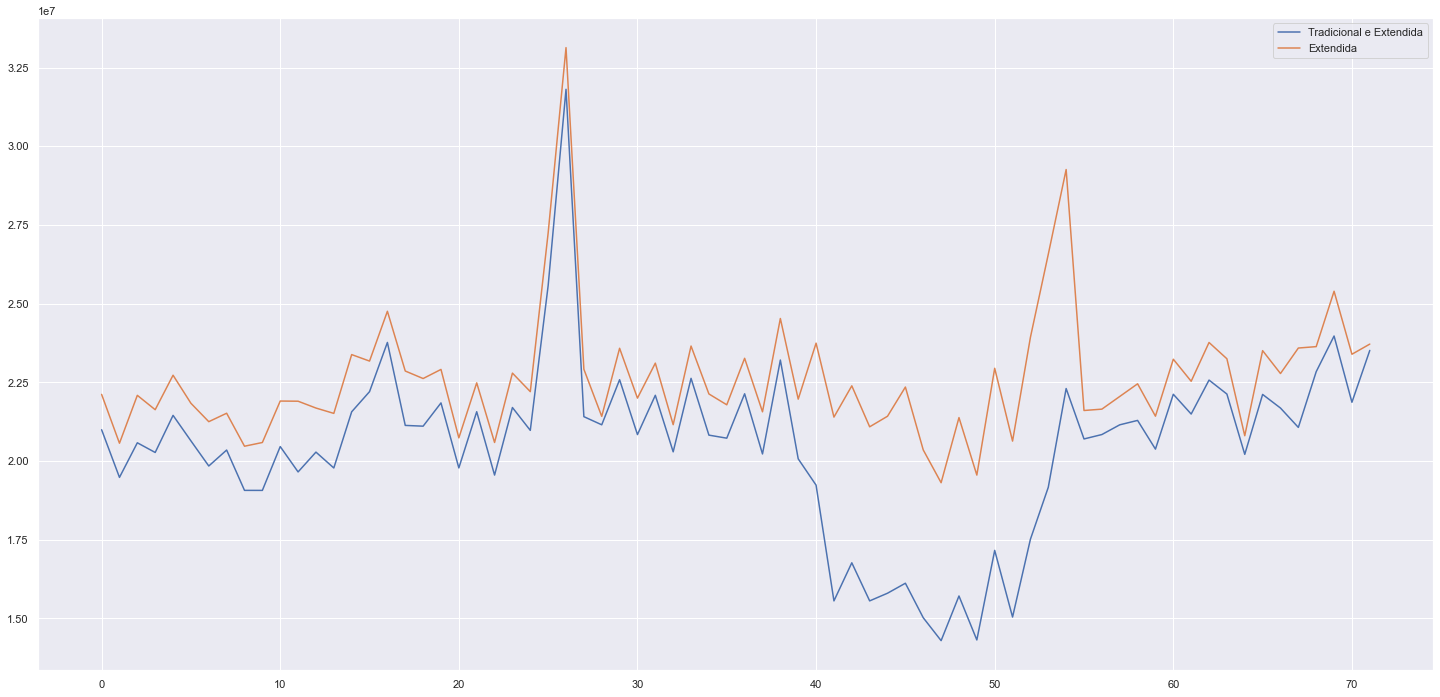

In [40]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels= ['Tradicional e Extendida', 'Extendida']);

### **H7** Lojas abertas durante o feriado de Natal deveriam vender mais
**FALSA** Lojas **abertas durante o Natal** vendem **Menos**

<AxesSubplot:xlabel='year', ylabel='sales'>

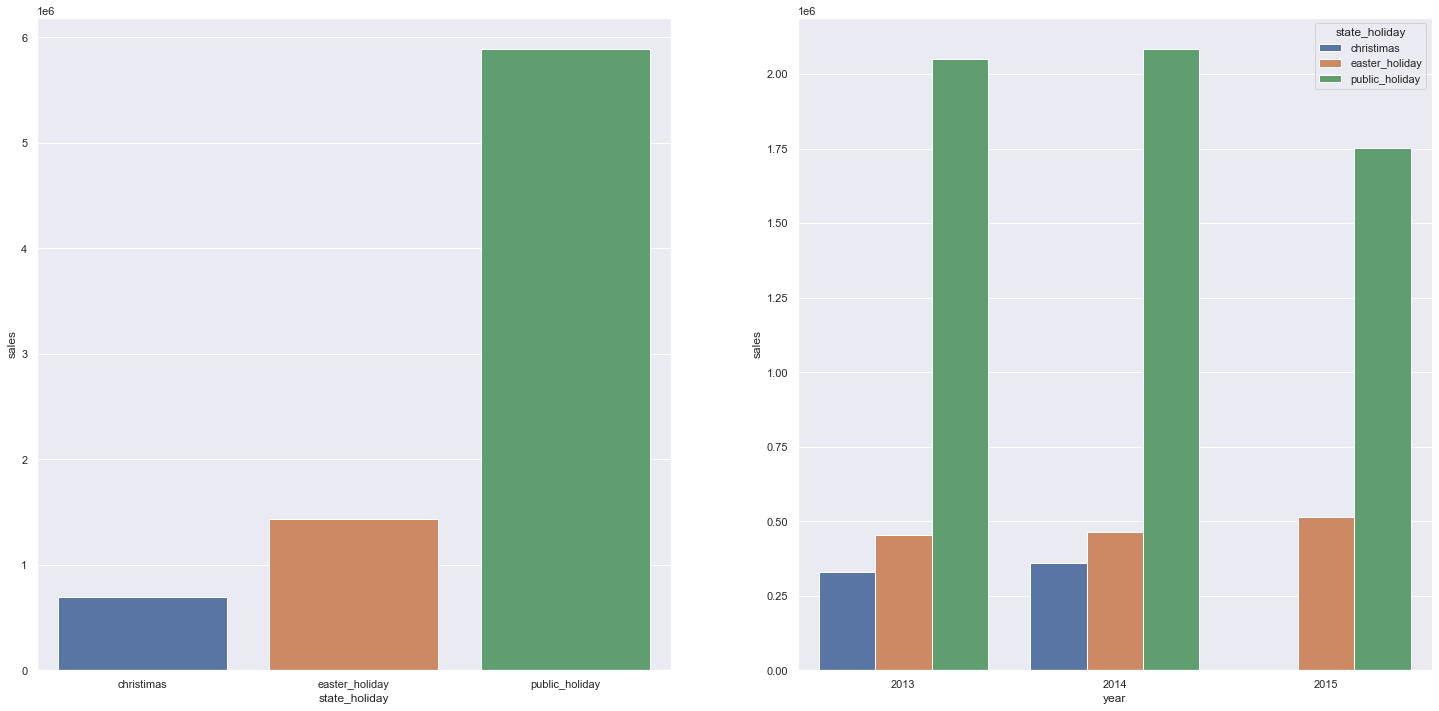

In [41]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)

### H8 Lojas deveriam vender mais ao longo dos anos
**FALSA** Lojas **Vendem Menos** ao **Longo dos Anos** 

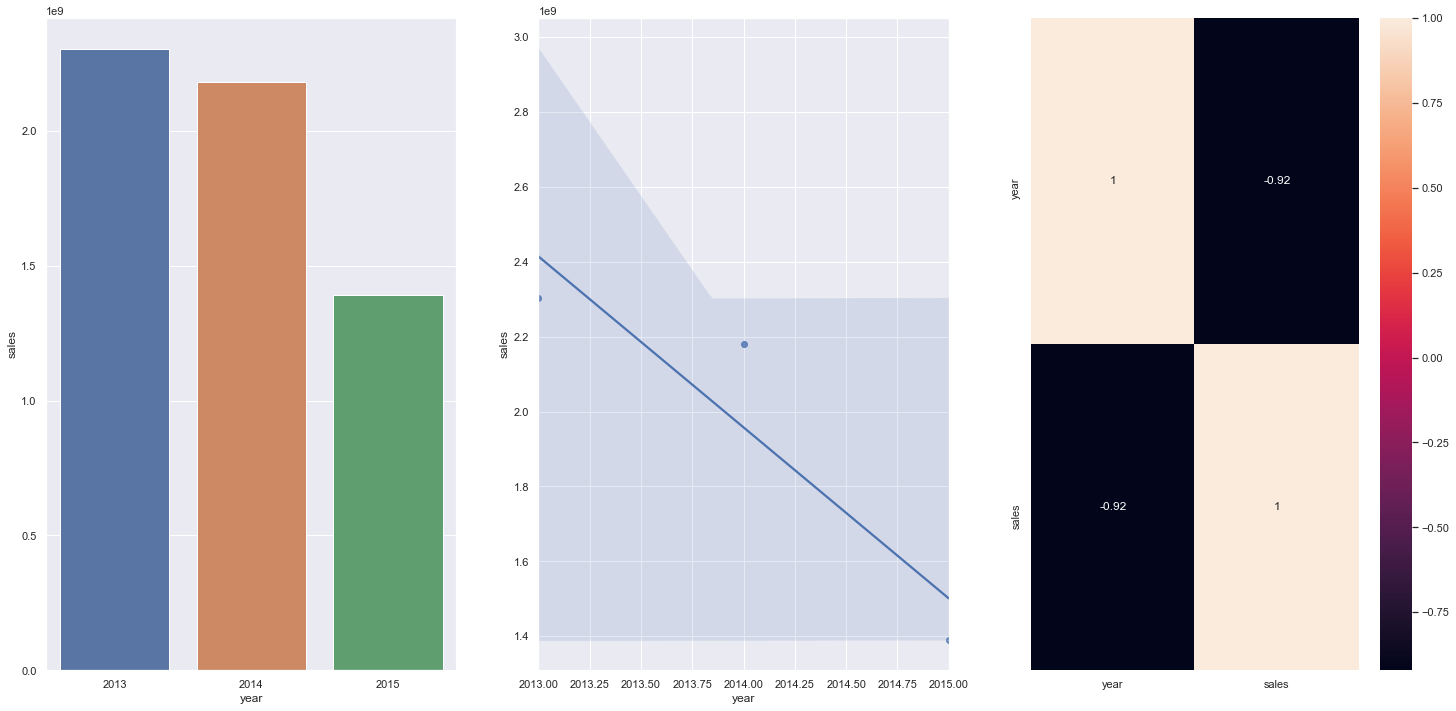

In [42]:
plt.subplot(1, 3, 1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H9 Lojas deveriam vender mais no segundo semestre do ano
**FALSA** Lojas **Vendem Menos** no **Segundo Semestre do Ano**

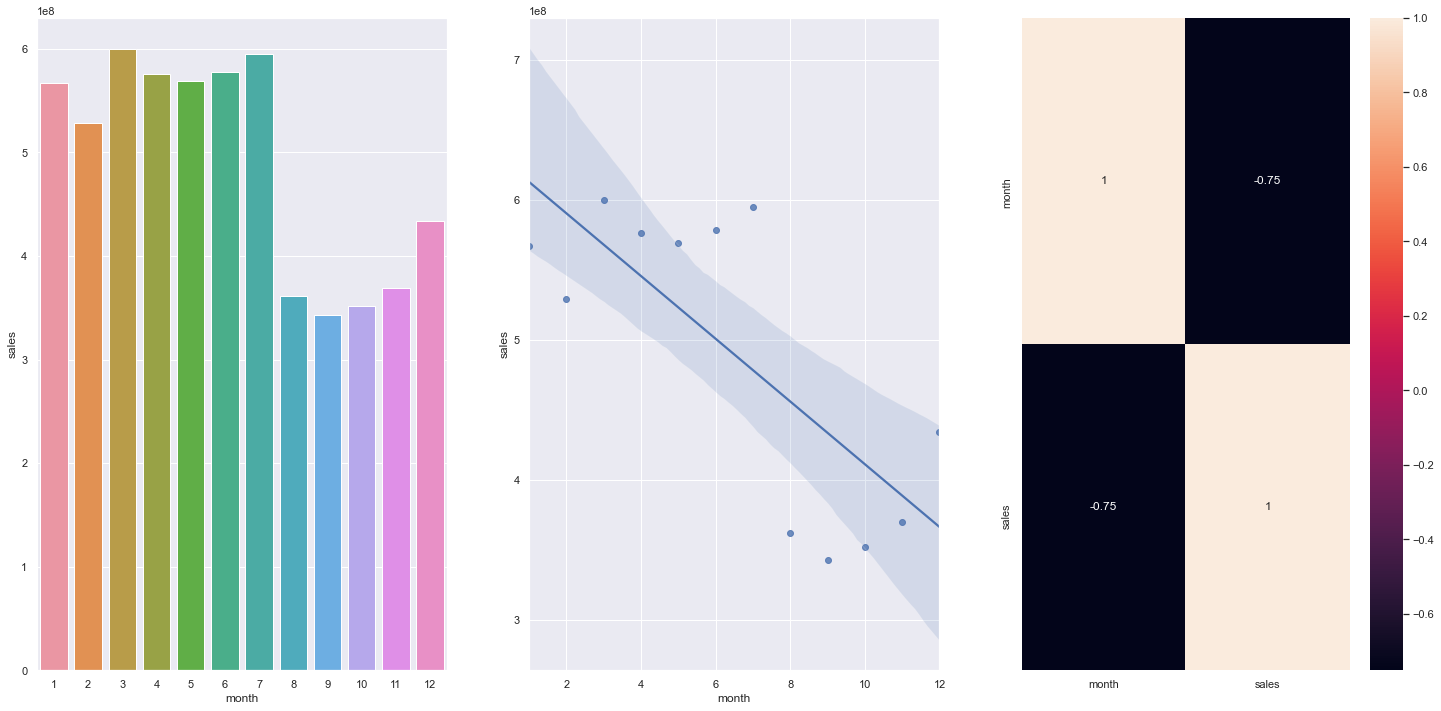

In [43]:
plt.subplot(1, 3, 1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10 Lojas deveriam vender mais depois do dia 10 de cada mês
**VERDADEIRA** Lojas **Vendem Mais depois do Dia 10**

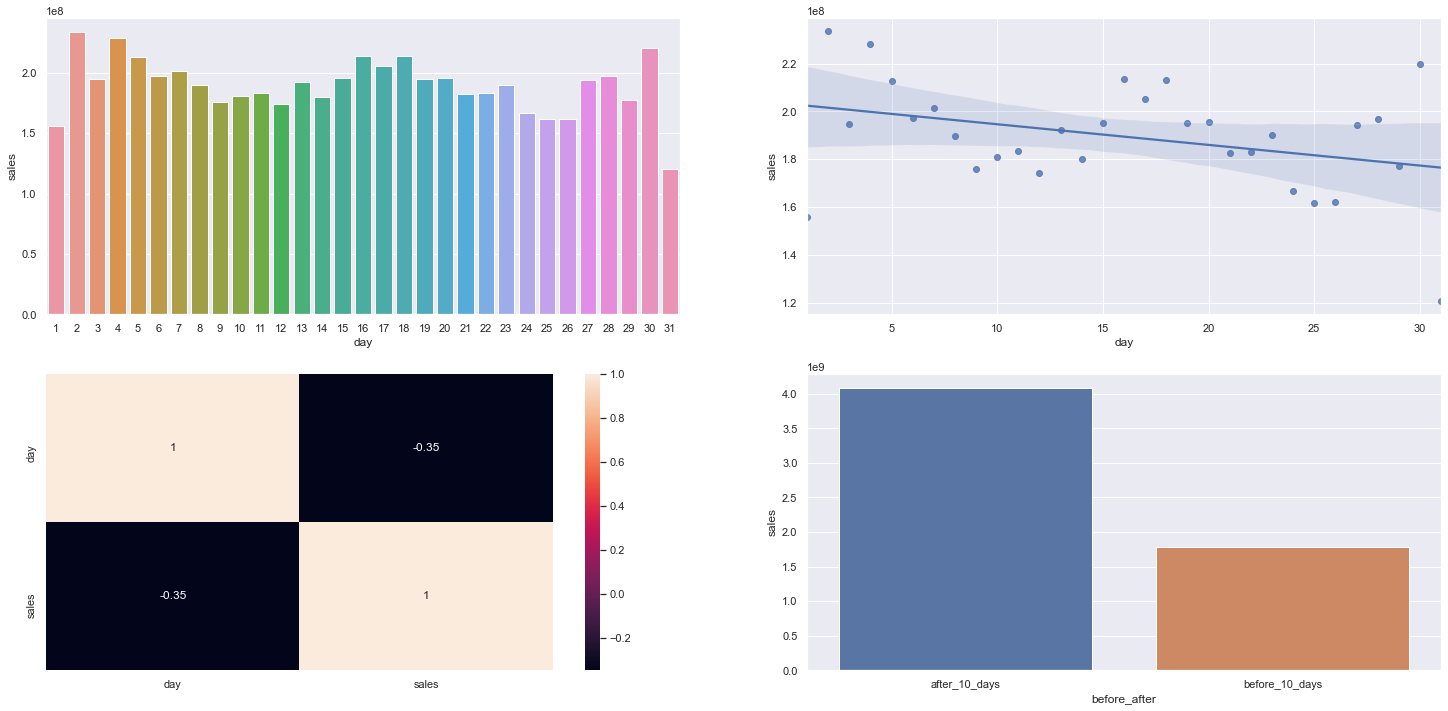

In [44]:
plt.subplot(2, 2, 1)
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <=9 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

### H11 Lojas deveriam vender menos aos finais de semana
**VERDADEIRA** Lojas **Vendem Menos nos Finais de Semana**

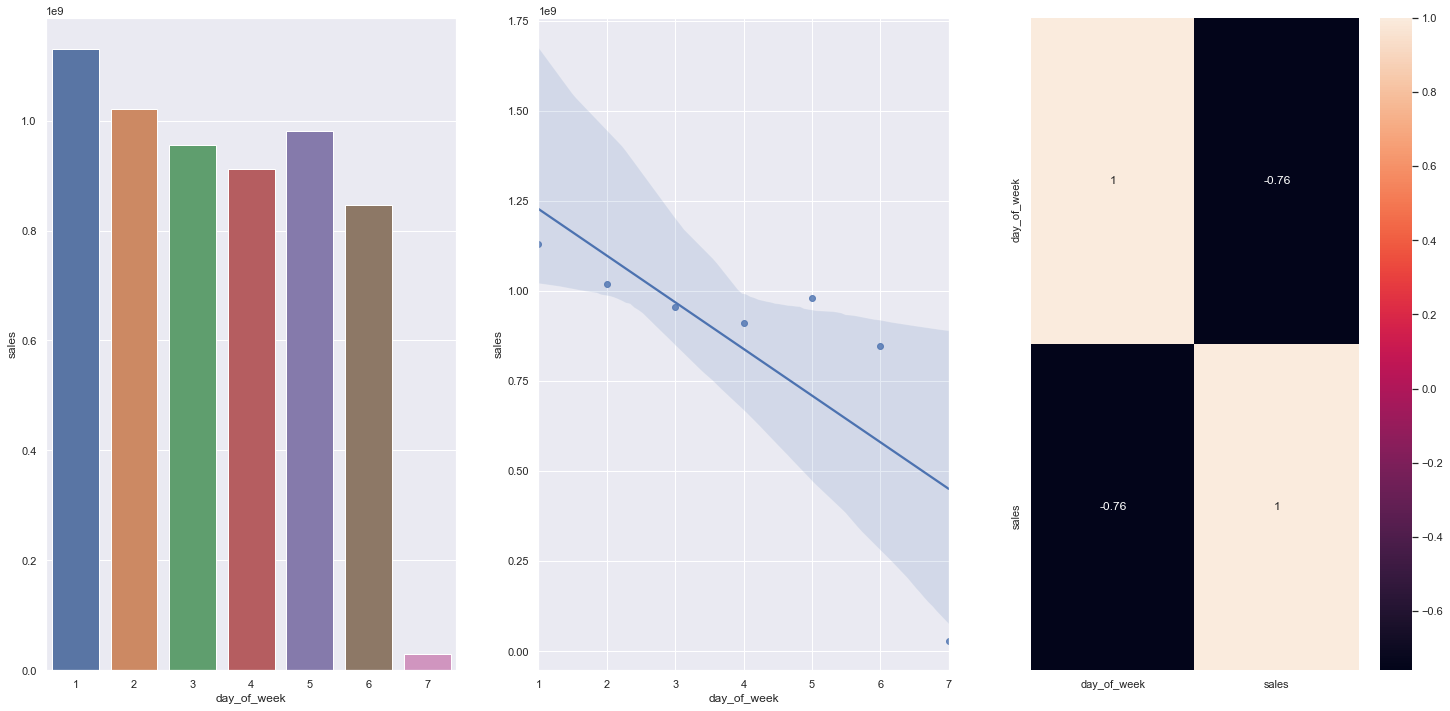

In [45]:
plt.subplot(1, 3, 1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12 Lojas deveriam vender menos durante os feriados escolares
**VERDADEIRA** Lojas **Vendem Menos** nos **Feriados Escolares, exceto Julho e Agosto**

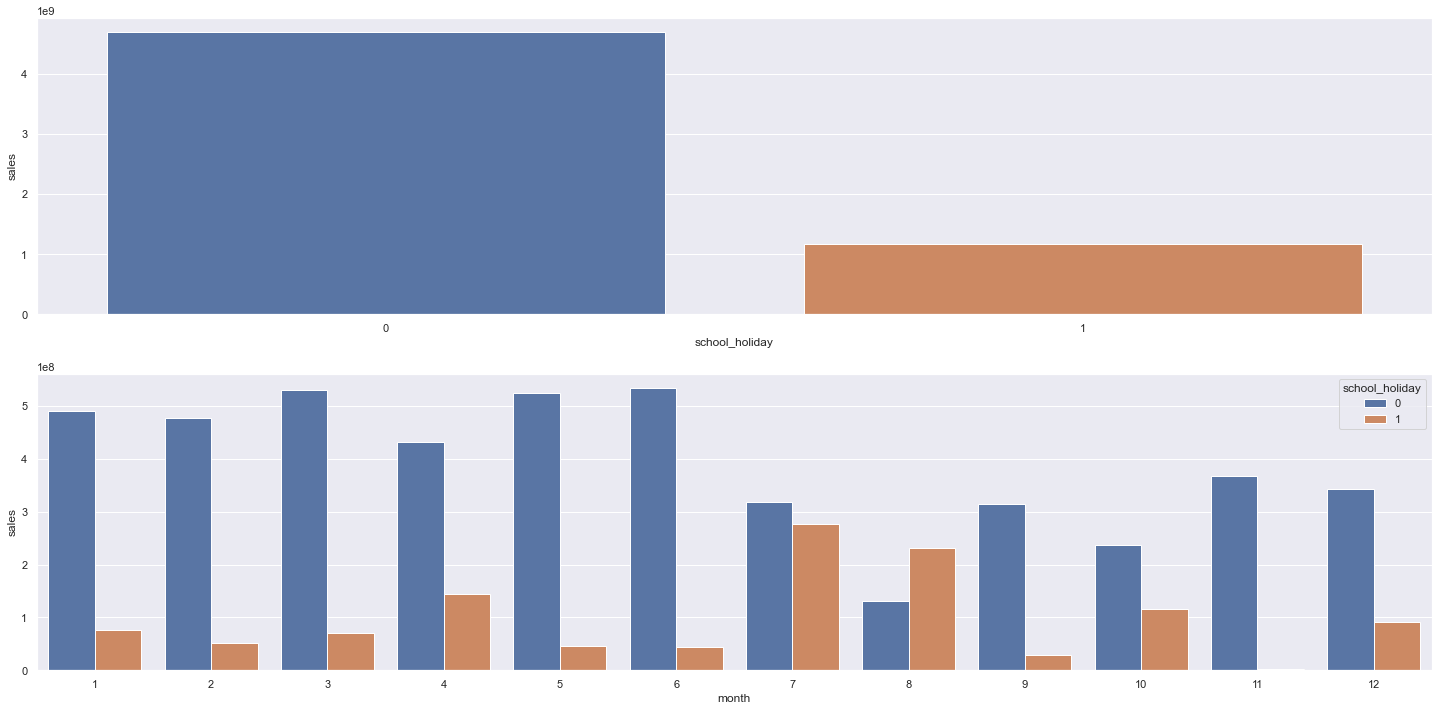

In [46]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

## 4.3 Multivariate Analysis

### Numerical Attributes

<AxesSubplot:>

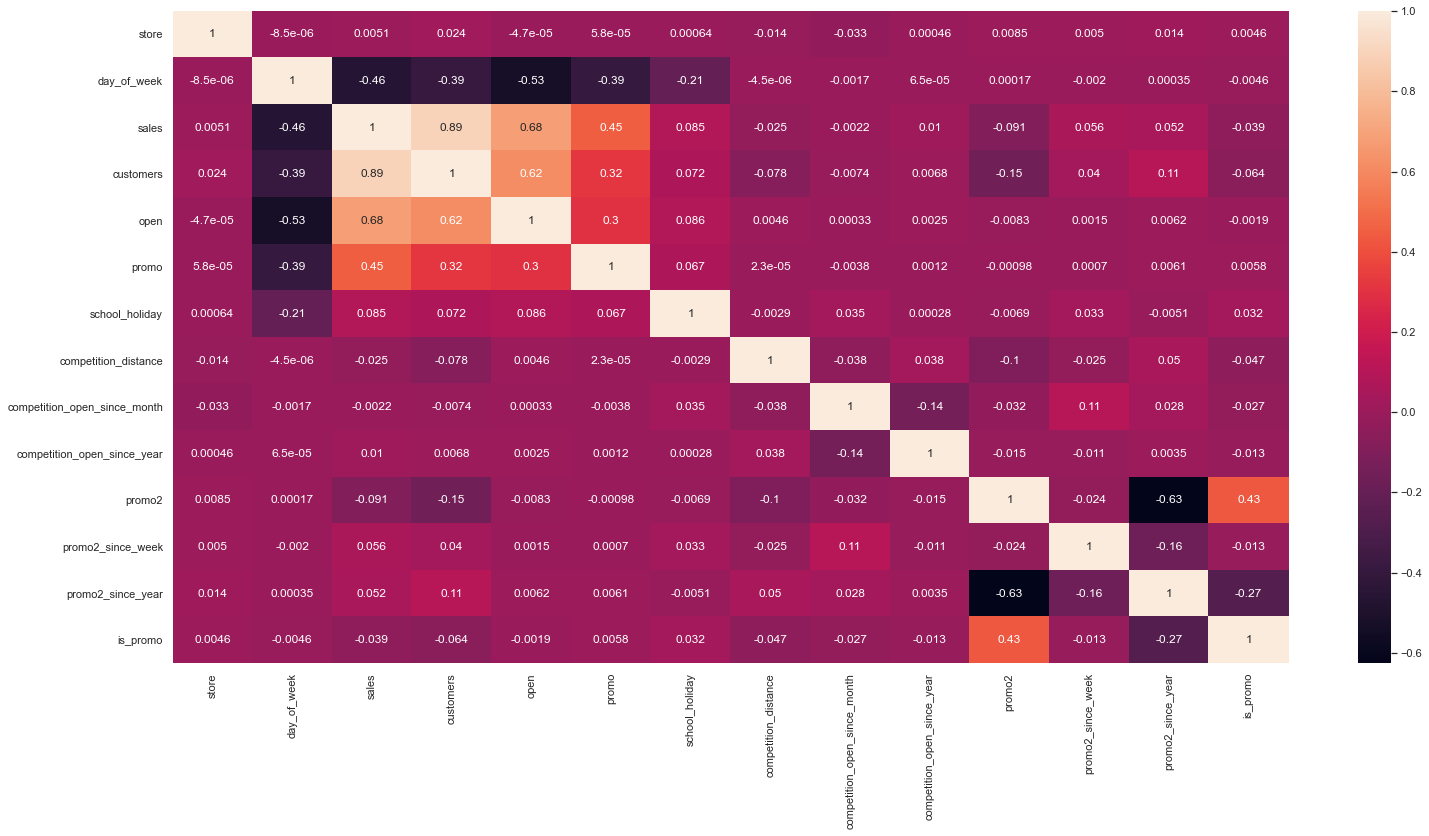

In [47]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical Attributes

In [48]:
a = df4.select_dtypes(include='object')

a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [49]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]
              })

d = d.set_index( d.columns)

# 5.0 Data Preparation

In [50]:
df5 = df4.copy()

## 5.1 Normalization

## 5.2 Rescaling

In [51]:
a = df5.select_dtypes(include= ['int64', 'float64'])


C:\Users\Riva\anaconda3\envs\DS em Producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='competition_distance'>

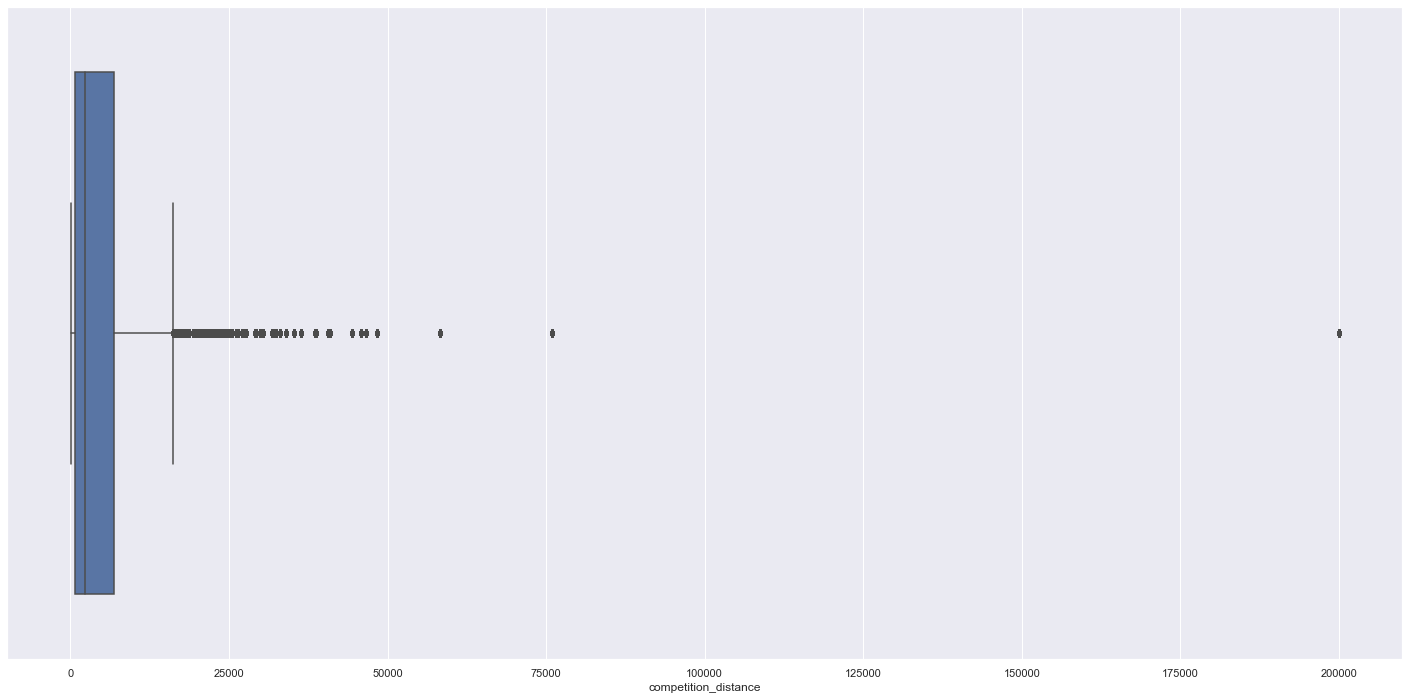

In [52]:
sns.boxplot(df5['competition_distance'])

In [53]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values)

# year
df5['year'] = mms.fit_transform( df5[['year']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values)

## 5.3 Encoding

In [54]:
# stateholiday - OneHot
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

# store type - Label
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)



## 5.4 Transformation

In [55]:
df5['sales'] = np.log1p( df5['sales'] )

In [56]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2. * np.pi/12) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2. * np.pi/12) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2. * np.pi/30) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2. * np.pi/30) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2. * np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2. * np.pi/52) ) )

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2. * np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2. * np.pi/7) ) )

# 6.0 Feature Selection

In [57]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test

In [58]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']

df6 = df6.drop( cols_drop, axis=1)

In [59]:
df6[['store', 'date']].groupby( 'store').max().reset_index()['date'][0] - datetime.timedelta( days= 6*7)

Timestamp('2015-06-19 00:00:00')

In [60]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

## 6.2 Boruta as Feature Selector

In [61]:
#define training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

#define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

#define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n)

### 6.2.1 Best Features from Boruta

In [62]:
#cols_selected = boruta.support_.tolist()

#best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_select].columns.to_list()

#not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d( X_train_fs.columns, cols_selected_boruta))

In [70]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos'
]

#columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

#final features
#cols_selected_boruta.extend( feat_to_add)

# 7.0 Machine Learning Modeling

In [64]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.1 Average Model

In [65]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [66]:
#model 
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#perfomance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


## 7.3 Linear Regression Regularized Model - Lasso

In [67]:
#model 
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#perfomance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


In [71]:
x_training = X_train[ cols_selected_boruta_full ]

In [85]:
for k in reversed( range( 1, 6 ) ):
    
    print(f' KFold Number {k} \n')
    
    #start and end date for validation
    validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
    validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

    #filtering dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

    #training and validation dataset
    #training
    xtraining = training.drop( ['date', 'sales'], axis=1)
    ytraining = training['sales']

    #validation
    xvalidation = validation.drop( ['date', 'sales'], axis=1)
    yvalidation = validation['sales']

    #model
    lr = LinearRegression().fit(xtraining, ytraining)

    #prediction
    yhat_lr = lr.predict(xvalidation)

    #performance
    ml_error('Linerar Regression', np.expm1(yvalidation), np.expm1(yhat_lr))
    print(lr_result,'\n')

 KFold Number 5 

          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1867.089774  0.292694  2671.049215 

 KFold Number 4 

          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1867.089774  0.292694  2671.049215 

 KFold Number 3 

          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1867.089774  0.292694  2671.049215 

 KFold Number 2 

          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1867.089774  0.292694  2671.049215 

 KFold Number 1 

          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1867.089774  0.292694  2671.049215 

